### Importações

In [39]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Carregamento e tratamento de dados

In [40]:
# Carregar e ler arquivos .csv
df = pd.read_csv('onlinefoods.csv')
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes


In [41]:
# Exclusão de colunas irrelevantes
df.drop(columns=['Output', 'Unnamed: 12', 'latitude', 'longitude', 'Pin code', 'Feedback'], inplace=True)
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size
0,20,Female,Single,Student,No Income,Post Graduate,4
1,24,Female,Single,Student,Below Rs.10000,Graduate,3
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3
3,22,Female,Single,Student,No Income,Graduate,6
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4


In [42]:
#Renomeando colunas
df.rename(columns={'Monthly Income': 'Income(m)', 'Educational Qualifications': 'Schooling Level'}, inplace=True)
df.head()

,Age,Gender,Marital Status,Occupation,Income(m),Schooling Level,Family size
0,20,Female,Single,Student,No Income,Post Graduate,4
1,24,Female,Single,Student,Below Rs.10000,Graduate,3
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3
3,22,Female,Single,Student,No Income,Graduate,6
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4


In [43]:
# Verificando valores com baixa frequência na coluna Schooling Level
df['Schooling Level'].value_counts()

Schooling Level
Graduate         177
Post Graduate    174
Ph.D              23
School            12
Uneducated         2
Name: count, dtype: int64

In [44]:
# Agrupando os valores menos frequentes
relevant_categories = ['Graduate', 'Post Graduate']
df['Schooling Level'] = df['Schooling Level'].apply(lambda x: x if x in relevant_categories else 'Others')
df['Schooling Level'].value_counts()


Schooling Level
Graduate         177
Post Graduate    174
Others            37
Name: count, dtype: int64

### Análise e preparação de dados

In [47]:
# Verificação de valores nulos
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

Age                0.0
Gender             0.0
Marital Status     0.0
Occupation         0.0
Income(m)          0.0
Schooling Level    0.0
Family size        0.0
dtype: float64

In [50]:
# Codificação OneHotEncoder para variáveis categóricas
ohe = OneHotEncoder()
ohe.fit(df[['Marital Status', 'Gender', 'Occupation', 'Income(m)', 'Schooling Level']])
df_encoded = ohe.transform(df[['Marital Status', 'Gender', 'Occupation', 'Income(m)', 'Schooling Level']])
df_encoded

<388x17 sparse matrix of type '<class 'numpy.float64'>'
	with 1940 stored elements in Compressed Sparse Row format>

In [51]:
# Converter o resultado da codificação para DataFrame e adicionar ao DataFrame original
df_encoded = pd.DataFrame(df_encoded.toarray(), columns= ohe.get_feature_names_out(['Marital Status', 'Gender', 'Occupation', 'Income(m)', 'Schooling Level']))
df_encoded

,Marital Status_Married,Marital Status_Prefer not to say,Marital Status_Single,Gender_Female,Gender_Male,Occupation_Employee,Occupation_House wife,Occupation_Self Employeed,Occupation_Student,Income(m)_10001 to 25000,Income(m)_25001 to 50000,Income(m)_Below Rs.10000,Income(m)_More than 50000,Income(m)_No Income,Schooling Level_Graduate,Schooling Level_Others,Schooling Level_Post Graduate
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
384,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
385,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
386,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [52]:
# Concatenar o DataFrame original com o DataFrame codificado e remover colunas irrelevantes
df = pd.concat([df, df_encoded], axis = 1)
df.drop(columns=['Age','Marital Status_Prefer not to say', 'Marital Status', 'Gender', 'Gender_Female', 'Occupation', 'Income(m)', 'Schooling Level', 
                 'Marital Status_Single', 'Income(m)_No Income'], inplace=True)
df.head()

,Family size,Marital Status_Married,Gender_Male,Occupation_Employee,Occupation_House wife,Occupation_Self Employeed,Occupation_Student,Income(m)_10001 to 25000,Income(m)_25001 to 50000,Income(m)_Below Rs.10000,Income(m)_More than 50000,Schooling Level_Graduate,Schooling Level_Others,Schooling Level_Post Graduate
0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [53]:
print(df.dtypes)

Family size                        int64
Marital Status_Married           float64
Gender_Male                      float64
Occupation_Employee              float64
Occupation_House wife            float64
Occupation_Self Employeed        float64
Occupation_Student               float64
Income(m)_10001 to 25000         float64
Income(m)_25001 to 50000         float64
Income(m)_Below Rs.10000         float64
Income(m)_More than 50000        float64
Schooling Level_Graduate         float64
Schooling Level_Others           float64
Schooling Level_Post Graduate    float64
dtype: object


<Axes: xlabel='Marital Status_Married', ylabel='count'>

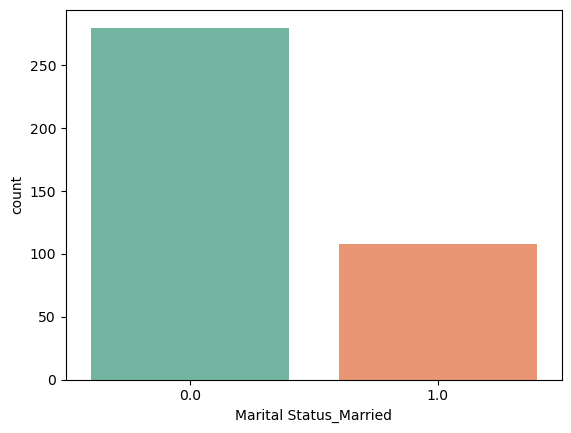

In [54]:
# Visualizar a distribuição da variável alvo 'Marital Status_Married'
sns.countplot(x = 'Marital Status_Married', palette = 'Set2', data = df)

### Divisão e Balanceamento dos Dados

In [55]:
# Separar as variáveis independentes (X) da variável dependente (y)
X = df.drop('Marital Status_Married', axis = 1)
y = df['Marital Status_Married']

In [56]:
X.shape, y.shape

((388, 13), (388,))

In [57]:
# Dividir os dados em conjuntos de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [58]:
X_treino.shape, y_treino.shape

((271, 13), (271,))

In [59]:
# Balancear o conjunto de treino utilizando oversampling
ros = RandomOverSampler(random_state=0)
X_treino, y_treino = ros.fit_resample(X_treino, y_treino)

In [60]:
# Verificar a distribuição da variável alvo após o balanceamento
pd.Series(y_treino).value_counts()

Marital Status_Married
0.0    196
1.0    196
Name: count, dtype: int64

In [61]:
X_treino.shape, y_treino.shape

((392, 13), (392,))

### Alta correlação

In [62]:
# Calcular a matriz de correlação para um conjunto de variáveis
lista_corr = ['Family size', 'Marital Status_Married', 'Gender_Male', 'Occupation_Employee', 'Occupation_House wife', 'Occupation_Self Employeed','Occupation_Student', 'Income(m)_10001 to 25000',
              'Income(m)_25001 to 50000', 'Income(m)_Below Rs.10000', 'Income(m)_More than 50000', 'Schooling Level_Graduate', 'Schooling Level_Post Graduate', 'Schooling Level_Others']

In [63]:
# Verificar alta correlação entre variáveis
corr_delivery = df[lista_corr].corr()
display(corr_delivery)


,Family size,Marital Status_Married,Gender_Male,Occupation_Employee,Occupation_House wife,Occupation_Self Employeed,Occupation_Student,Income(m)_10001 to 25000,Income(m)_25001 to 50000,Income(m)_Below Rs.10000,Income(m)_More than 50000,Schooling Level_Graduate,Schooling Level_Post Graduate,Schooling Level_Others
Family size,1.000000,0.224432,-0.082488,-0.000621,0.170953,0.070803,-0.100133,-0.015759,-0.011909,-0.070200,0.112511,-0.002777,-0.087882,0.153518
Marital Status_Married,0.224432,1.000000,-0.032472,0.401940,0.209921,0.232080,-0.595007,0.008517,0.252563,-0.069299,0.404002,0.100815,-0.282511,0.307408
Gender_Male,-0.082488,-0.032472,1.000000,0.016810,-0.178207,0.106900,-0.035901,-0.028428,-0.061024,0.057198,0.192291,0.091270,-0.079150,-0.020753
Occupation_Employee,-0.000621,0.401940,0.016810,1.000000,-0.101873,-0.265817,-0.706977,0.162972,0.454430,0.009057,0.246845,0.159387,-0.168044,0.014257
Occupation_House wife,0.170953,0.209921,-0.178207,-0.101873,1.000000,-0.061962,-0.164796,-0.055816,-0.071669,-0.040441,-0.067203,-0.038009,-0.138953,0.299742
Occupation_Self Employeed,0.070803,0.232080,0.106900,-0.265817,-0.061962,1.000000,-0.430001,0.203178,0.085623,-0.105521,0.332687,0.065270,-0.152961,0.148321
Occupation_Student,-0.100133,-0.595007,-0.035901,-0.706977,-0.164796,-0.430001,1.000000,-0.274410,-0.456832,0.077063,-0.438174,-0.180795,0.303015,-0.206495
Income(m)_10001 to 25000,-0.015759,0.008517,-0.028428,0.162972,-0.055816,0.203178,-0.274410,1.000000,-0.168457,-0.095055,-0.157960,0.088424,-0.067658,-0.035386
Income(m)_25001 to 50000,-0.011909,0.252563,-0.061024,0.454430,-0.071669,0.085623,-0.456832,-0.168457,1.000000,-0.122052,-0.202823,0.142407,-0.080549,-0.105103
Income(m)_Below Rs.10000,-0.070200,-0.069299,0.057198,0.009057,-0.040441,-0.105521,0.077063,-0.095055,-0.122052,1.000000,-0.114447,-0.050679,0.058860,-0.013725


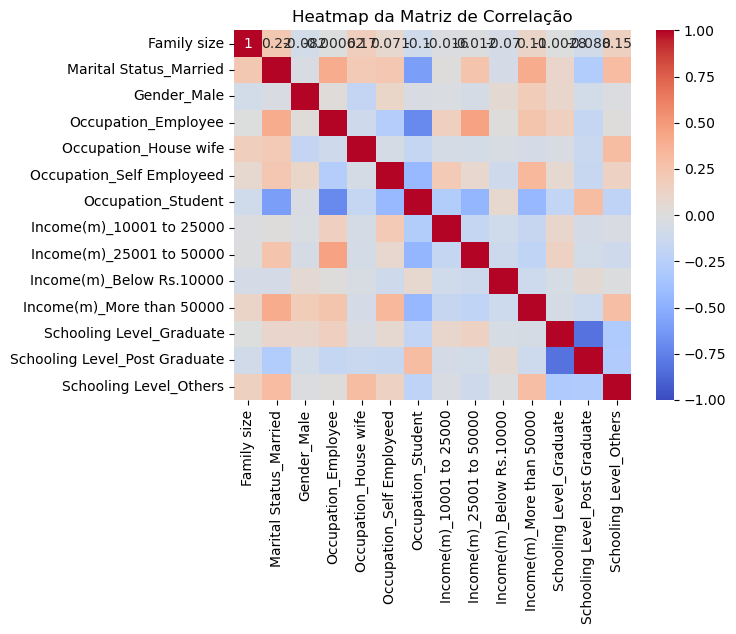

In [64]:
# Plotando o heatmap
sns.heatmap(corr_delivery, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap da Matriz de Correlação')
plt.show()

### Treinamento e Seleção de Variáveis

In [65]:
# Treinar um modelo RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_treino, y_treino)

RandomForestClassifier(random_state=0)

In [66]:
# Seleção de variáveis com base na importância das características
model = SelectFromModel(clf, prefit=True)
X_treino_selected = model.transform(X_treino)
X_teste_selected = model.transform(X_teste)

c:\Users\Thiago\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Thiago\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [67]:
# Obter os nomes das melhores características selecionadas
feature_idx = model.get_support()
feature_names = X.columns[feature_idx]
print("Variáveis selecionadas:", feature_names)

Variáveis selecionadas: Index(['Family size', 'Occupation_Employee', 'Occupation_Student',
       'Income(m)_More than 50000'],
      dtype='object')


### Hiperparametrização e Avaliação

In [68]:
# Definir a grade de hiperparâmetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

In [69]:
# Encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_treino_selected, y_treino)


c:\Users\Thiago\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
38 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Thiago\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Thiago\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Thiago\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Thiago\anaconda3\Lib\site-pa

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [70]:
# Obter o melhor modelo 
best_model = grid_search.best_estimator_
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [71]:
# Avaliação do modelo
y_pred = best_model.predict(X_teste_selected)
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83        84
         1.0       0.56      0.67      0.61        33

    accuracy                           0.76       117
   macro avg       0.71      0.73      0.72       117
weighted avg       0.78      0.76      0.77       117



In [72]:
accuracy = accuracy_score(y_teste, y_pred)
accuracy

0.7606837606837606

### Visualização

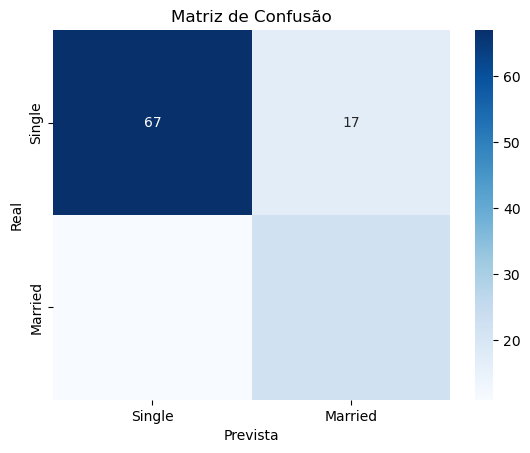

In [73]:
# Gerar a matriz de confusão para visualizar os dados
conf_matrix = confusion_matrix(y_teste, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Single', 'Married'], yticklabels=['Single', 'Married'])
plt.xlabel('Prevista')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [78]:
# Obter as importâncias das variáveis
importances = best_model.feature_importances_
feature_names = X.columns[model.get_support()]
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


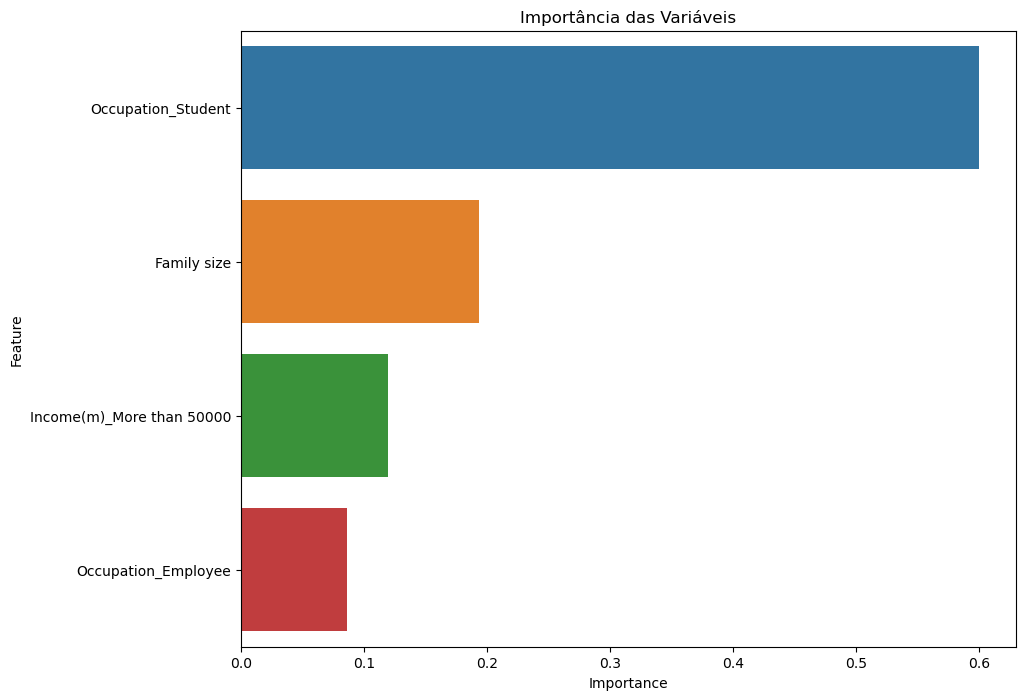

In [79]:
# Plotar a importância das variáveis para saber o pefil que mais faz pedidos
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importância das Variáveis')
plt.show()